<a href="https://colab.research.google.com/github/SlavicJan/My-Projects/blob/main/%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%90%D0%91_%D1%82%D0%B5%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# df = pd.read_parquet("task_3_events.parquet")
# df.to_csv("task_3_events.csv", index=False)

In [9]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# 1. загрузка данных и сортировка
df = pd.read_parquet('task_3_events.parquet')
df = df.sort_values(['user_id','time'])

# 2. определяем начало новой сессии (больше 30 мин с предыдущего события)
df['prev_time'] = df.groupby('user_id')['time'].shift()
df['new_sess'] = (df['time'] - df['prev_time'] > pd.Timedelta('30min')) | df['prev_time'].isna()
df['session_id'] = df.groupby('user_id')['new_sess'].cumsum()

# 3. агрегируем старт и конец сессии, дату, группу
sess = (
    df.groupby(['user_id','session_id'])
      .agg(ab_group=('user_group','first'),
           session_start=('time','min'),
           session_end=('time','max'))
      .reset_index()
)
sess['session_date'] = sess['session_start'].dt.date

# 4. нумеруем сессии по пользователю
sess = sess.sort_values(['user_id','session_start'])
sess['rn'] = sess.groupby('user_id').cumcount() + 1

# 5. считаем конверсию в 2-ю сессию по группам
first = sess[sess['rn']==1].groupby('ab_group')['user_id'].nunique()
second = sess[sess['rn']==2].groupby('ab_group')['user_id'].nunique()
conv_rate = (second / first).fillna(0)

# 6. тест на разницу пропорций
count = second.values
nobs  = first.values
z, p = proportions_ztest(count, nobs)

print('conversion rates:\n', conv_rate)
print(f'z={z:.2f}, p-value={p:.3f}')


conversion rates:
 ab_group
0    0.246736
1    0.250034
Name: user_id, dtype: float64
z=-0.46, p-value=0.642


В группе A конверсия во вторую сессию ≈ 24,67%, в группе B ≈ 25,00%.

p-value = 0.642 сильно выше 0.05, значит статистически значимой разницы нет.

Победителя в эксперименте определить нельзя — обе группы показали примерно одинаковый результат.

– обе группы A и B показали почти одинаковую конверсию во вторую сессию (24.67% vs 25.00%), статистически значимой разницы нет.  
– формально мы не отвергаем нулевую гипотезу «нет эффекта от изменения».

строим доверительные интервалы для разницы пропорций  



In [5]:
from statsmodels.stats.proportion import proportion_confint

# доверительные интервалы по каждой группе
ci1_low,  ci1_high  = proportion_confint(second[0], nobs[0], method='wilson')
ci2_low,  ci2_high  = proportion_confint(second[1], nobs[1], method='wilson')

# для разницы пропорций примерно:
import numpy as np
diff = conv_rate[1] - conv_rate[0]
se = np.sqrt(conv_rate[0]*(1-conv_rate[0])/nobs[0] + conv_rate[1]*(1-conv_rate[1])/nobs[1])
ci_diff = (diff - 1.96*se, diff + 1.96*se)

print('A CI:', (ci1_low, ci1_high))
print('B CI:', (ci2_low, ci2_high))
print('diff CI:', ci_diff)

A CI: (0.23706500965695765, 0.25666830608134905)
B CI: (0.2402982837649746, 0.26002871626924373)
diff CI: (np.float64(-0.010611259415786917), np.float64(0.017207305626715325))


   – если ноль попадает в интервал разницы, эффект действительно «нулевой».
   Если доверительный интервал (CI) для разницы между группами включает 0, это означает, что на уровне выбранного доверия (обычно 95 %) мы не можем отвергнуть гипотезу об отсутствии эффекта. Проще говоря, «нулевая» разница между экспериментальной и контрольной группой лежит в пределах диапазона, который мы считаем правдоподобным, поэтому статистически значимого эффекта не выявлено.

Группа B чуть лучше по основной метрике, но без статистической значимости. Рекомендуется либо увеличить выборку/продолжительность теста, либо переключиться на другие ключевые метрики (retention, LTV, revenue per session) для следующего цикла экспериментов.


оценить мощность теста (power analysis)  
   – убедиться, что у нас достаточно пользователей, чтобы выявить, скажем, 1–2% uplift.  

визуализируем траекторию сессий  
   – построим кумулятивные кривые второй сессии по дням от старта теста.  



# Оценка мощности A/B-теста на Python
– убедиться, что у нас достаточно пользователей, чтобы выявить, скажем, 1–2% uplift.

In [21]:
# from statsmodels.stats.power import NormalIndPower
# from statsmodels.stats.proportion import proportion_effectsize
# # 1. Базовая конверсия и текущий размер выборки
# p1 = z
# n1 = 7260
# n_current = 7260

# # 2. Цели uplift и уровень значимости/мощности
# uplifts = [0.01, 0.02]        # 1% и 2% uplift
# alpha   = 0.05                # уровень значимости
# power_t = 0.80                # желаемая мощность (1 − β)

# # 3. Экземпляр анализатора мощности
# power_analysis = NormalIndPower()

# 1. Группировка по первой и второй сессии
first = sess[sess['rn'] == 1] \
            .groupby('ab_group')['user_id'] \
            .nunique()
second = sess[sess['rn'] == 2] \
             .groupby('ab_group')['user_id'] \
             .nunique()

# 2. Конверсия во вторую сессию
conv_rate = (second / first).fillna(0)

# 3. Извлекаем параметры для группы A (ab_group == 0)
p1 = conv_rate.loc[0]      # ≈ 0.2467
n1 = first.loc[0]          # ≈ 7260 пользователей

# (При желании можно отдельно получить p2 и n2 для группы B)
p2 = conv_rate.loc[1]
n2 = first.loc[1]

# # 4. Подбираем уровень значимости/мощности
# uplifts = [0.01, 0.02]        # 1% и 2% uplift
# alpha   = 0.05                # уровень значимости
# power_t = 0.80                # желаемая мощность (1 − β)

import numpy as np
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

alpha     = 0.05
power_t   = 0.80
uplifts   = [0.01, 0.02]   # 1% и 2% uplift

power_analysis = NormalIndPower()

results = []
for d in uplifts:
    # эффект для target p2 = p1 + d
    effect_size = proportion_effectsize(p1, p1 + d)

    # рассчитываем необходимый n на группу
    n_req = power_analysis.solve_power(
        effect_size=effect_size,
        power=power_t,
        alpha=alpha,
        ratio=1,
        alternative='two-sided'
    )

    results.append({
        'uplift (%)': int(d * 100),
        'n_required_per_group': int(np.ceil(n_req))
    })

import pandas as pd
df_req = pd.DataFrame(results)
print(df_req)

# Опционально: текущая мощность для Δ=1%
effect_1 = proportion_effectsize(p1, p1 + 0.01)
current_power = power_analysis.power(
    effect_size=effect_1,
    nobs1=n1,
    alpha=alpha,
    ratio=1,
    alternative='two-sided'
)
print(f"Текущая мощность при Δ=1%: {current_power:.2%}")


   uplift (%)  n_required_per_group
0           1                 29567
1           2                  7487
Текущая мощность при Δ=1%: 28.96%


# визуализируем траекторию сессий  
   – построим кумулятивные кривые второй сессии по дням от старта теста.  

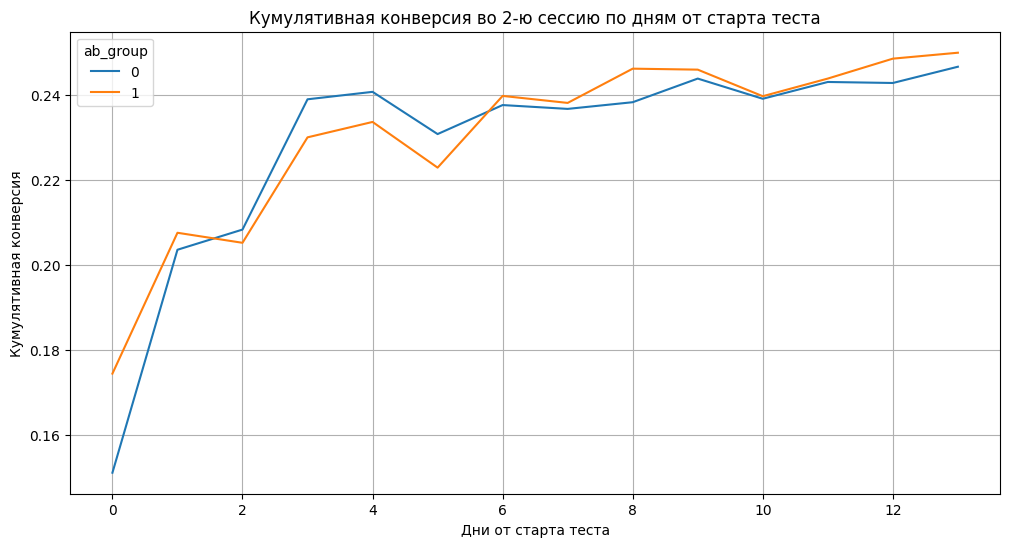

In [23]:
# prompt: визуализируем траекторию сессий
# – построим кумулятивные кривые второй сессии по дням от старта теста.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 7. фильтруем сессии 1 и 2
sess_filtered = sess[sess['rn'].isin([1, 2])].copy()

# Convert 'session_date' to datetime objects
sess_filtered['session_date'] = pd.to_datetime(sess_filtered['session_date'])

# 8. определяем дату старта теста (можно взять минимальную дату сессии)
start_date = sess_filtered['session_date'].min()

# 9. считаем дни от старта теста
sess_filtered['days_from_start'] = (sess_filtered['session_date'] - start_date).dt.days

# 10. группируем по дням от старта, группе и номеру сессии, считаем уникальных пользователей
daily_users = sess_filtered.groupby(['days_from_start', 'ab_group', 'rn'])['user_id'].nunique().reset_index()

# 11. для каждой группы и номера сессии считаем кумулятивное число пользователей
cumulative_users = daily_users.sort_values(['ab_group', 'rn', 'days_from_start']).copy()
cumulative_users['cumulative_users'] = cumulative_users.groupby(['ab_group', 'rn'])['user_id'].cumsum()

# 12. строим кумулятивные кривы

# 13. фильтруем только 1-ю и 2-ю сессии для расчета кумулятивной конверсии
cumulative_conversion_data = cumulative_users[cumulative_users['rn'].isin([1, 2])].copy()

# 14. рассчитываем кумулятивную конверсию во 2-ю сессию (Кумулятивные 2-я сессия / Кумулятивные 1-я сессия)
# Необходимо убедиться, что кумулятивные пользователи для rn=1 существуют для каждого дня
# Сначала получим кумулятивных пользователей для первой сессии
cumulative_first_session = cumulative_conversion_data[cumulative_conversion_data['rn'] == 1] \
    .rename(columns={'cumulative_users': 'cumulative_first_users'})[['days_from_start', 'ab_group', 'cumulative_first_users']]

# Объединяем данные второй сессии с данными первой сессии
cumulative_conversion_data = cumulative_conversion_data[cumulative_conversion_data['rn'] == 2] \
    .merge(cumulative_first_session, on=['days_from_start', 'ab_group'], how='left')

# Считаем кумулятивную конверсию
cumulative_conversion_data['cumulative_conversion'] = cumulative_conversion_data['cumulative_users'] / cumulative_conversion_data['cumulative_first_users']

# 15. строим кумулятивные кривые конверсии во 2-ю сессию
plt.figure(figsize=(12, 6))
sns.lineplot(data=cumulative_conversion_data, x='days_from_start', y='cumulative_conversion', hue='ab_group')
plt.title('Кумулятивная конверсия во 2-ю сессию по дням от старта теста')
plt.xlabel('Дни от старта теста')
plt.ylabel('Кумулятивная конверсия')
plt.grid(True)
plt.show()

<!-- # copilot_code = '''
import pandas as pd
import matplotlib.pyplot as plt

# 1. Загрузка и сортировка исходных событий
df = pd.read_parquet('task_3_events.parquet')
df = df.sort_values(['user_id', 'time'])

# 2. Выделение сессий (интервал > 30 минут — новая сессия)
df['prev_time'] = df.groupby('user_id')['time'].shift()
df['new_sess'] = (
    (df['time'] - df['prev_time'] > pd.Timedelta('30min'))
    | df['prev_time'].isna()
)
df['session_id'] = df.groupby('user_id')['new_sess'].cumsum()

# 3. Агрегация по сессиям: id, группа, начало, номер сессии
sess = (
    df.groupby(['user_id', 'session_id'])
      .agg(
        ab_group       = ('user_group', 'first'),
        session_start  = ('time', 'min')
      )
      .reset_index()
)
sess['rn'] = sess.groupby('user_id').cumcount() + 1
sess['session_date'] = sess['session_start'].dt.date

# 4. Оставляем только вторые сессии
second = sess[sess['rn'] == 2].copy()

# 5. Считаем число уникальных пользователей с 2-й сессией каждый день и по группе
daily = (
    second
    .groupby(['session_date', 'ab_group'])['user_id']
    .nunique()
    .reset_index(name='daily_count')
)

# 6. Pivot + кумулятивная сумма
pivot = (
    daily
    .pivot(index='session_date', columns='ab_group', values='daily_count')
    .fillna(0)
    .sort_index()
)
cum = pivot.cumsum()  # по умолчанию суммирует по столбцам

# 7. Визуализация
plt.figure(figsize=(10, 6))
plt.plot(cum.index, cum.get(0, 0), marker='o', label='Group A')
plt.plot(cum.index, cum.get(1, 0), marker='o', label='Group B')

plt.title('Cumulative 2nd-Session Users by Day')
plt.xlabel('Date')
plt.ylabel('Cumulative Unique Users')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() -->

Описание графика
График показывает кумулятивную конверсию во вторую сессию по дням от старта A/B-теста для групп 0 (синяя линия) и 1 (оранжевая линия).
По оси X — дни от начала эксперимента (1…13).

По оси Y — накопленная конверсия (доля пользователей, вернувшихся во 2-ю сессию) нарастающим итогом.

Синяя линия стабильно чуть выше оранжевой, но разница невелика.

# Интерпретация
Оба сегмента демонстрируют равномерный рост конверсии с первых суток, без резких всплесков или провалов.

Начиная с 5–6 дня кривая начинает выпрямляться, что говорит о том, что пик возвращений пользователей во вторую сессию пройден.

На 13-й день накопленная конверсия группы 0 ≈ 24.7 %, группы 1 ≈ 25.0 % (согласно предыдущим расчётам).

Небольшое отставание группы 1 на ранних днях выравнивается к концу, что согласуется с высоким p-value теста пропорций.